In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'transactions-fraud-datasets' dataset.
Path to dataset files: /kaggle/input/transactions-fraud-datasets


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [3]:
cards_data = pd.read_csv(path + "/cards_data.csv")
transactions_data = pd.read_csv(path + "/transactions_data.csv")
users_data = pd.read_csv(path + "/users_data.csv")

mcc_codes = pd.read_json(path + "/mcc_codes.json",typ='series').reset_index().rename(columns={'index':'mcc_code',0:'mcc_description'})
train_fraud_labels = pd.read_json(path + "/train_fraud_labels.json").reset_index().rename(columns={'index':'transaction_id',0:'fraud'})

In [4]:
def get_data_card(df, name="Dataset"):
    print("="*50)
    print(f"Summary for {name}")
    print("="*50)

    print(f"\nShape of data: {df.shape}")
    print(f"Count of duplicate values: {df.duplicated().sum()}")

    print("\nNull values per column:\n")
    print(df.isna().sum())

    print("\nData info:")
    df.info()

In [5]:
cards_data

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6141,5361,185,Amex,Credit,300609782832003,01/2024,663,YES,1,$6900,11/2000,2013,No
6142,2711,185,Visa,Credit,4718517475996018,01/2021,492,YES,2,$5700,04/2012,2012,No
6143,1305,1007,Mastercard,Credit,5929512204765914,08/2020,237,NO,2,$9200,02/2012,2012,No
6144,743,1110,Mastercard,Debit,5589768928167462,01/2020,630,YES,1,$28074,01/2020,2020,No


In [6]:
get_data_card(cards_data)

Summary for Dataset

Shape of data: (6146, 13)
Count of duplicate values: 0

Null values per column:

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cv

In [7]:
# Convert expires column to datetime format
cards_data['expires'] = pd.to_datetime(cards_data['expires']).dt.to_period('M')
cards_data['acct_open_date'] = pd.to_datetime(cards_data['acct_open_date']).dt.to_period('M')

In [8]:
value_counts_cards_data = [cards_data['card_brand'], cards_data['card_type'], cards_data['has_chip'], cards_data["num_cards_issued"], cards_data['card_on_dark_web'] ]
for col in value_counts_cards_data:
    print(col.value_counts())
    print("-"*50)

card_brand
Mastercard    3209
Visa          2326
Amex           402
Discover       209
Name: count, dtype: int64
--------------------------------------------------
card_type
Debit              3511
Credit             2057
Debit (Prepaid)     578
Name: count, dtype: int64
--------------------------------------------------
has_chip
YES    5500
NO      646
Name: count, dtype: int64
--------------------------------------------------
num_cards_issued
1    3114
2    2972
3      60
Name: count, dtype: int64
--------------------------------------------------
card_on_dark_web
No    6146
Name: count, dtype: int64
--------------------------------------------------


In [9]:
transactions_data

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,$1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN
13305911,23761869,2019-10-31 23:56:00,1766,2066,$12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN
13305912,23761870,2019-10-31 23:57:00,199,1031,$40.44,Swipe Transaction,2925,Allen,TX,75002.0,4900,NaN
13305913,23761873,2019-10-31 23:58:00,1986,5443,$4.00,Chip Transaction,46284,Daly City,CA,94014.0,5411,NaN


In [10]:
get_data_card(transactions_data)

Summary for Dataset

Shape of data: (13305915, 12)
Count of duplicate values: 0

Null values per column:

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int6

In [11]:
transactions_data[transactions_data['merchant_state'].isna()][['merchant_city', 'merchant_state']].head(20)

,merchant_city,merchant_state
7,ONLINE,NaN
8,ONLINE,NaN
18,ONLINE,NaN
24,ONLINE,NaN
26,ONLINE,NaN
29,ONLINE,NaN
35,ONLINE,NaN
37,ONLINE,NaN
41,ONLINE,NaN
43,ONLINE,NaN


In [12]:
# Count the most frequent merchant_city values where merchant_state is missing
transactions_data.loc[transactions_data['merchant_state'].isna(), 'merchant_city'].value_counts()

,count
merchant_city,
ONLINE,1563700


In [13]:
# Based on the data check: when merchant_city = 'ONLINE', merchant_state is always missing → fill with 'ONLINE'
transactions_data['merchant_state'] = transactions_data['merchant_state'].fillna('ONLINE')

In [14]:
# Verify that there are no missing values left in merchant_state
transactions_data['merchant_state'].isna().sum()

np.int64(0)

In [15]:
# Display a sample of rows where merchant_state was filled with 'ONLINE'
transactions_data[transactions_data['merchant_state'] == 'ONLINE'].head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
7,7475335,2010-01-01 00:14:00,1684,2140,$26.46,Online Transaction,39021,ONLINE,ONLINE,NaN,4784,NaN
8,7475336,2010-01-01 00:21:00,335,5131,$261.58,Online Transaction,50292,ONLINE,ONLINE,NaN,7801,NaN
18,7475346,2010-01-01 00:34:00,394,4717,$26.04,Online Transaction,39021,ONLINE,ONLINE,NaN,4784,NaN
24,7475353,2010-01-01 00:43:00,301,3742,$10.17,Online Transaction,39021,ONLINE,ONLINE,NaN,4784,NaN
26,7475356,2010-01-01 00:45:00,566,3439,$16.86,Online Transaction,16798,ONLINE,ONLINE,NaN,4121,NaN


In [16]:
# Replace missing error values with 'NO_ERROR' to indicate absence of errors
transactions_data['errors'] = transactions_data['errors'].fillna('NO_ERROR')

# Fill missing values in 'zip' column with -1 as a numeric placeholder.
# Using -1 ensures we keep the column numeric (important for statistics/ML),
# while also marking these rows as "no valid ZIP code available".
transactions_data['zip'] = transactions_data['zip'].fillna(-1)

In [17]:
# Check that there are no NaN values left in the 'zip' or 'errors' columns
transactions_data[['zip', 'errors']].isna().sum()

,0
zip,0
errors,0


In [18]:
users_data

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,986,32,70,1987,7,Male,6577 Lexington Lane,40.65,-73.58,$23550,$48010,$87837,703,3
1996,1944,62,65,1957,11,Female,2 Elm Drive,38.95,-84.54,$24218,$49378,$104480,740,4
1997,185,47,67,1973,1,Female,276 Fifth Boulevard,40.66,-74.19,$15175,$30942,$71066,779,3
1998,1007,66,60,1954,2,Male,259 Valley Boulevard,40.24,-76.92,$25336,$54654,$27241,618,1


In [19]:
get_data_card(users_data)

Summary for Dataset

Shape of data: (2000, 14)
Count of duplicate values: 0

Null values per column:

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitud

In [20]:
mcc_codes

,mcc_code,mcc_description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees
...,...,...
104,7549,Towing Services
105,5941,Sporting Goods Stores
106,5722,Household Appliance Stores
107,3009,Fabricated Structural Metal Products


In [21]:
get_data_card(mcc_codes)

Summary for Dataset

Shape of data: (109, 2)
Count of duplicate values: 0

Null values per column:

mcc_code           0
mcc_description    0
dtype: int64

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mcc_code         109 non-null    int64 
 1   mcc_description  109 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [22]:
train_fraud_labels

,transaction_id,target
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No
...,...,...
8914958,14064699,No
8914959,7676538,No
8914960,15131030,No
8914961,17244732,No


In [23]:
get_data_card(train_fraud_labels)

Summary for Dataset

Shape of data: (8914963, 2)
Count of duplicate values: 0

Null values per column:

transaction_id    0
target            0
dtype: int64

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   transaction_id  int64 
 1   target          object
dtypes: int64(1), object(1)
memory usage: 136.0+ MB


In [24]:
# Save all cleaned DataFrames
cards_data.to_csv("cards_data.csv", index=False)
users_data.to_csv("users_data.csv", index=False)
transactions_data.to_csv("transactions_data.csv", index=False)
mcc_codes.to_csv("mcc_codes.csv", index=False)
train_fraud_labels.to_csv("train_fraud_labels.csv", index=False)


#visualization #

###Cards Data ###

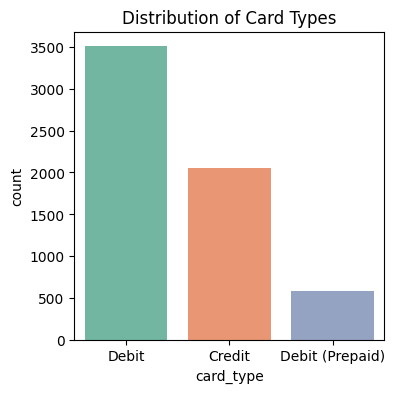

In [26]:
plt.figure(figsize=(4,4))
sns.countplot(x="card_type", data=cards_data, palette="Set2")
plt.title("Distribution of Card Types")
plt.show()

fig = px.pie(cards_data, names="card_type", title="Card Type Distribution")
fig.show()

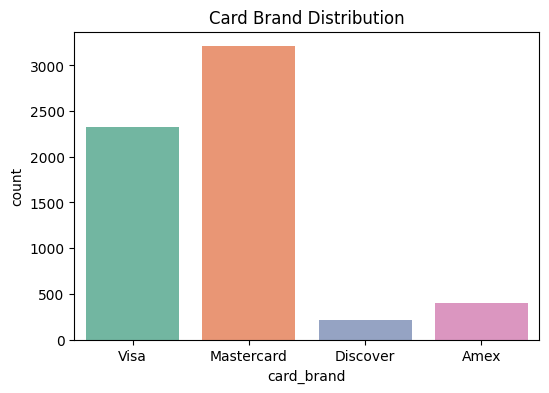

In [27]:
plt.figure(figsize=(6,4))
sns.countplot(x="card_brand", data=cards_data, palette="Set2")
plt.title("Card Brand Distribution")
plt.show()

fig = px.pie(cards_data, names="card_brand", title="Card Brand Distribution")
fig.show()

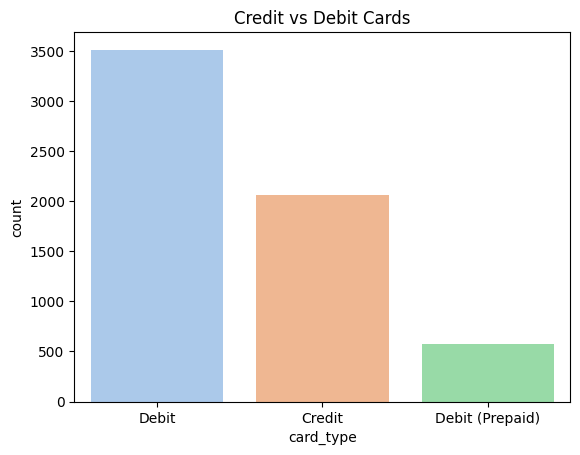

In [29]:
sns.countplot(x="card_type", data=cards_data, palette="pastel")
plt.title("Credit vs Debit Cards")
plt.show()

In [34]:
fig = px.histogram(cards_data, x="has_chip", color="has_chip", title="Cards with/without Chip", width= 600, height=400)
fig.show()

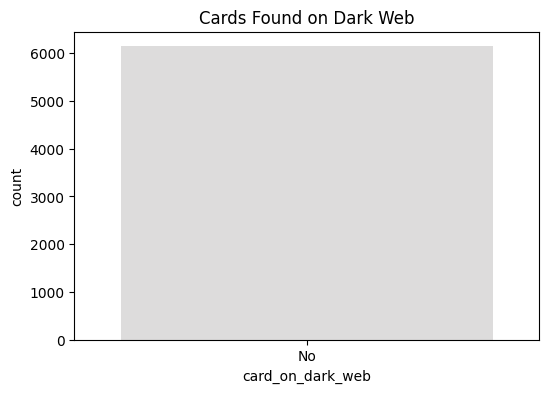

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(x="card_on_dark_web", data=cards_data , palette="coolwarm")
plt.title("Cards Found on Dark Web")
plt.show()

In [ ]:
# Set plot style
sns.set(style="whitegrid", palette="muted")

# 1. Distribution of transaction amounts
plt.figure(figsize=(10,5))
sns.histplot(transactions_data["amount"], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

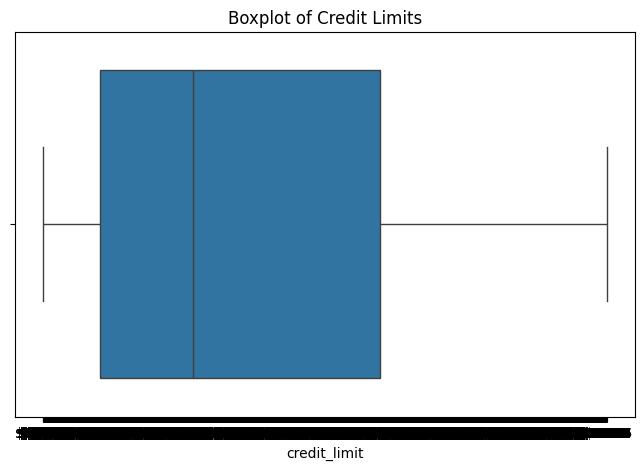

In [37]:
plt.figure(figsize=(8,5))
sns.boxplot(x=cards_data['credit_limit'])
plt.title("Boxplot of Credit Limits")
plt.show()

###Transactions Data ###

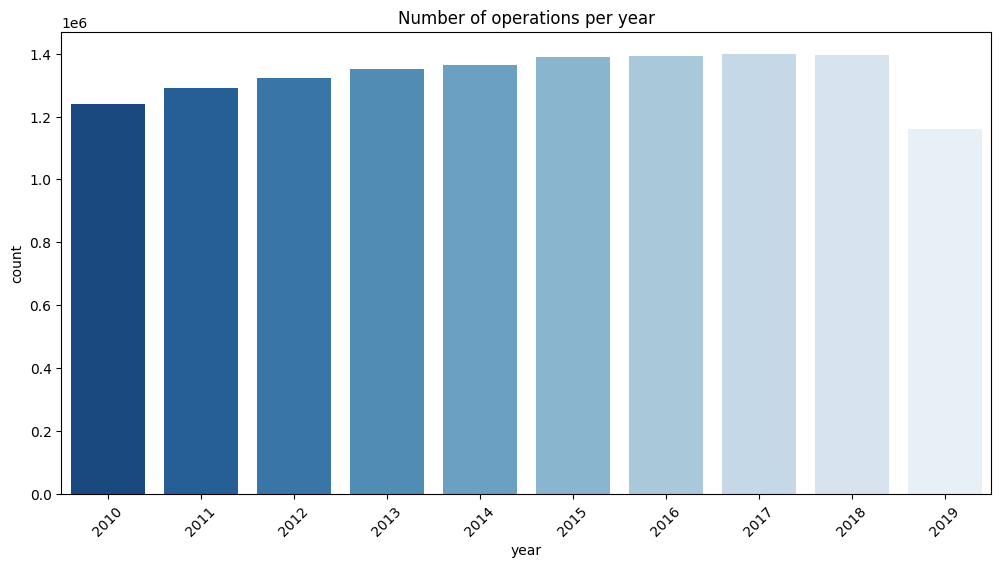

In [42]:
# Convert 'date' column to datetime objects
transactions_data['date'] = pd.to_datetime(transactions_data['date'])

# Extract the year from the 'date' column
transactions_data['year'] = transactions_data['date'].dt.year

plt.figure(figsize=(12,6))
sns.countplot(data=transactions_data, x='year', palette="Blues_r")
plt.title("Number of operations per year")
plt.xticks(rotation=45)
plt.show()

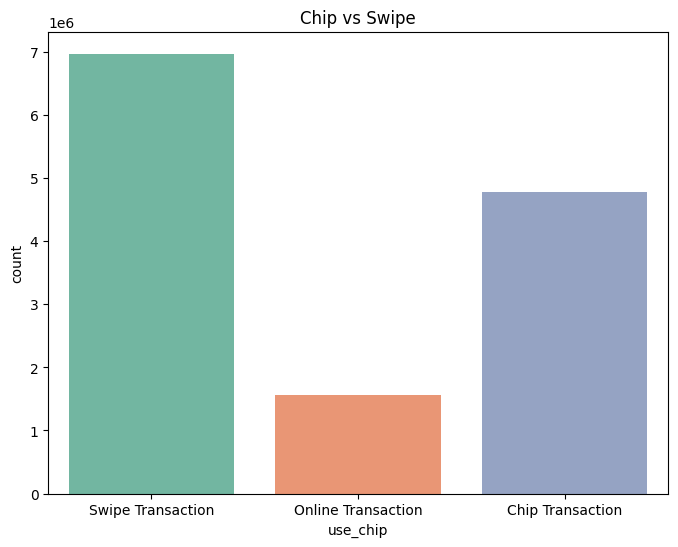

In [44]:
plt.figure(figsize=(8,6))
sns.countplot(data=transactions_data, x='use_chip', palette="Set2")
plt.title("Chip vs Swipe")
plt.show()

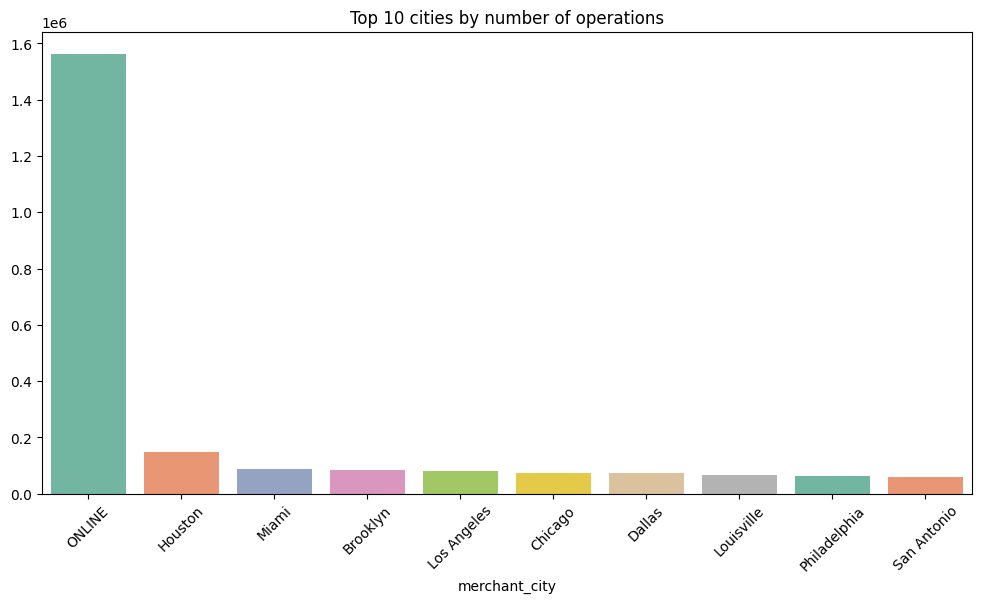

In [45]:
top_cities = transactions_data['merchant_city'].value_counts().nlargest(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_cities.index, y=top_cities.values, palette="Set2")
plt.title("Top 10 cities by number of operations")
plt.xticks(rotation=45)
plt.show()

In [46]:
fig = px.scatter(transactions_data.sample(5000),
                 x="date",
                 y="amount",
                 color="use_chip",
                 title="Amount vs Date (Sampled 5000 rows)")
fig.show()

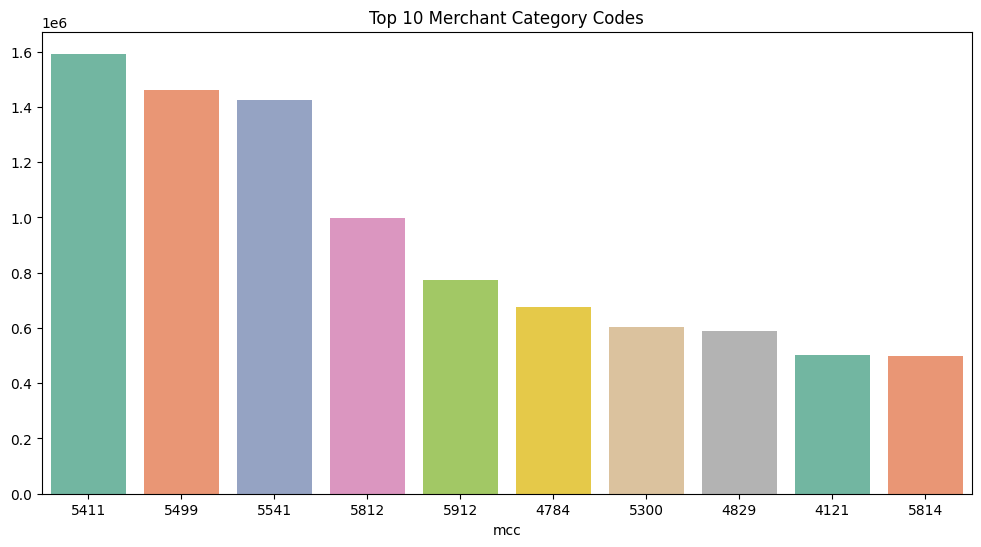

In [47]:
top_mcc = transactions_data['mcc'].value_counts().nlargest(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_mcc.index.astype(str), y=top_mcc.values, palette="Set2")
plt.title("Top 10 Merchant Category Codes")
plt.show()

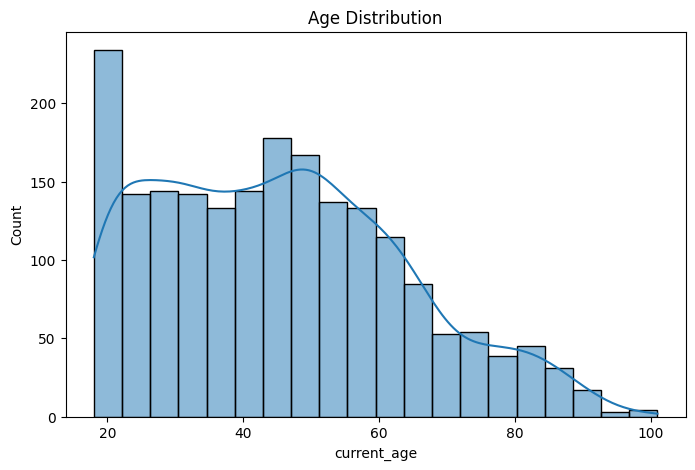

In [48]:
plt.figure(figsize=(8,5))
sns.histplot(users_data['current_age'], bins=20, kde=True)
plt.title("Age Distribution")
plt.show()

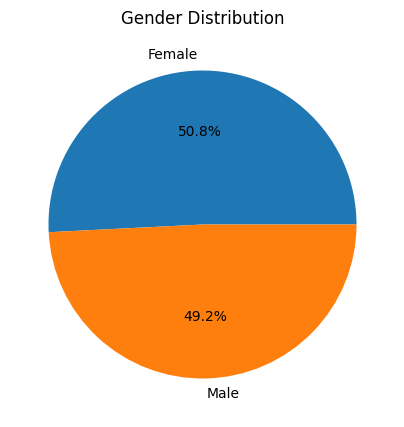

In [49]:
plt.figure(figsize=(5,5))
users_data['gender'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Gender Distribution")
plt.ylabel("")
plt.show()


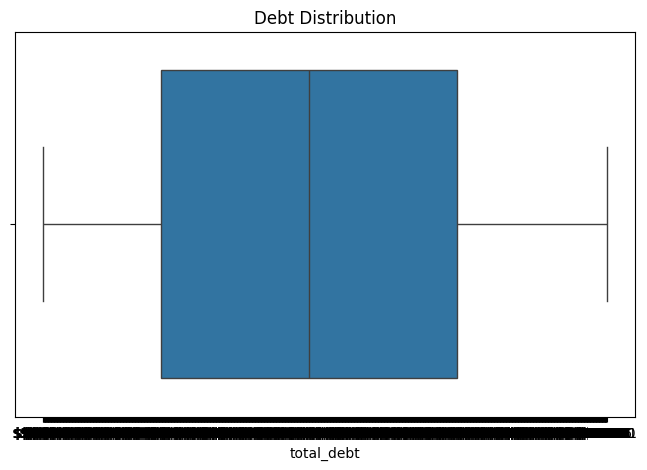

In [52]:
plt.figure(figsize=(8,5))
sns.boxplot(x=users_data['total_debt'])
plt.title("Debt Distribution")
plt.show()